In [52]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)
#config.update('jax_debug_nans', True) #this checks outputs for nans everytime and reruns the function with non-optimized mode.


import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)
from NODE_fns import NODE, NODE_vmap
from jax import grad, random, jit, vmap
import pickle
key = random.PRNGKey(0)
import jax

In [53]:
with open('saved/phi_norm_w.npy', 'rb') as f:
    [inp_mean, inp_stdv, out_mean, out_stdv] = pickle.load(f)
with open('saved/phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = Phi_params

In [54]:
def dPhi_NODE(taui):
    
    tau1, tau2, tau3 = taui
    tau1 = (tau1 - inp_mean)/inp_stdv
    tau2 = (tau2 - inp_mean)/inp_stdv
    tau3 = (tau3 - inp_mean)/inp_stdv

    N1 = NODE(tau1, NODE1_params)
    N2 = NODE(tau1 + tau2, NODE2_params)
    N3 = NODE(tau1 + tau2 + tau3, NODE3_params)
    N4 = NODE(tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3, NODE4_params) #I1^2
    N5 = NODE(tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3, NODE5_params) #I1^2 - 3I2

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    Phi1 = Phi1*out_stdv + out_mean
    Phi2 = Phi2*out_stdv + out_mean
    Phi3 = Phi3*out_stdv + out_mean
    return [Phi1, Phi2, Phi3]
dPhi_vmap = vmap(dPhi_NODE, in_axes=0, out_axes = 0)

def dPhi_gov(taui): #This function takes in tau matrix and spits out dphidtau
    etad = 1360
    etav = 175000
    tau1, tau2, tau3 = taui
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]
dPhi_gov_vmap = vmap(dPhi_gov)

In [55]:
tau1 = np.linspace(-100,100)
tau2 = np.zeros_like(tau1)
tau3 = np.zeros_like(tau2)
taui = np.array([tau1, tau2, tau3]).transpose()

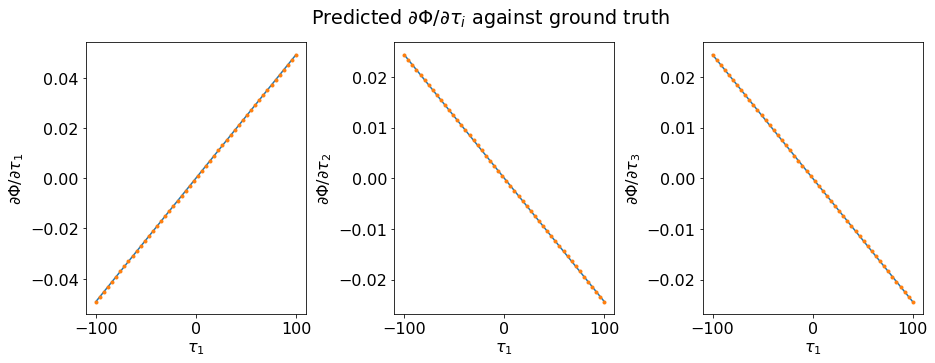

In [56]:
dPhi_pr = np.array(dPhi_vmap(taui))
dPhi_gt = np.array(dPhi_gov_vmap(taui))

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)
ax[0].plot(tau1, dPhi_pr[0])
ax[0].plot(tau1, dPhi_gt[0], '.')

ax[1].plot(tau1, dPhi_pr[1])
ax[1].plot(tau1, dPhi_gt[1], '.')

ax[2].plot(tau1, dPhi_pr[2])
ax[2].plot(tau1, dPhi_gt[2], '.')

for i, axi in enumerate(ax):
    axi.set(xlabel=r'$\tau_1$', ylabel = r'$\partial \Phi / \partial \tau_{i}$'.format(i=i+1))
fig.suptitle(r'Predicted $\partial \Phi / \partial \tau_i$ against ground truth')
pass

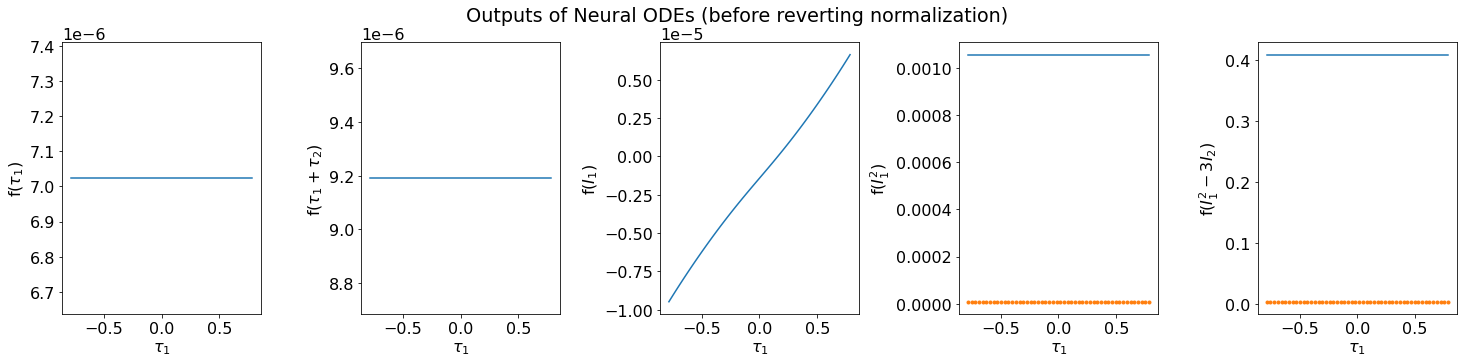

In [57]:
tau1 = np.linspace(-100,100)
tau2 = np.zeros_like(tau1)
tau3 = np.zeros_like(tau2)

tau1 = (tau1 - inp_mean)/inp_stdv
tau2 = (tau2 - inp_mean)/inp_stdv
tau3 = (tau3 - inp_mean)/inp_stdv

N1 = NODE_vmap(tau1, NODE1_params)
N2 = NODE_vmap(tau1 + tau2, NODE2_params)
N3 = NODE_vmap(tau1 + tau2 + tau3, NODE3_params)
N4 = NODE_vmap(tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3, NODE4_params) #I1^2
N5 = NODE_vmap(tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3, NODE5_params) #I1^2 - 3I2

Ns = [N1, N2, N3, N4, N5]
inputs = [r'$\tau_1$', r'$\tau_1+\tau_2$', r'$I_1$', r'$I_1^2$', r'$I_1^2 - 3I_2$']

dPhi_pr = np.array(dPhi_vmap(taui))
dPhi_gt = np.array(dPhi_gov_vmap(taui))

fig, ax = plt.subplots(1,5, figsize=(25,5))
fig.subplots_adjust(wspace=0.5)

for axi, N, input in zip(ax, Ns, inputs):
    axi.plot(tau1, N)
    axi.set(xlabel=r'$\tau_1$', ylabel = "f({i})".format(i=input))

# ax[4].set(ylim = [0.4082, 0.4083])
fig.suptitle(r'Outputs of Neural ODEs (before reverting normalization)')


# In Govindjee's function Phi = 1/9/etaV * I1^2 + 1/3/etaD * (I1^2 - 3I2)
# Then dPhi/d(I1^2) = 2/9/etaV * I1    (= 2*N4*I1)    => N4 = 1/9/etaV
# And dPhi/d(I1^2-3I2) = 1/3/etaD      (= N5)         => N5 = 1/3/etaD
etad = 1360
etav = 175000
ax[3].plot(tau1, 1/9/etav/out_stdv*np.ones_like(tau1),'.')
ax[4].plot(tau1, 1/3/etad/out_stdv*np.ones_like(tau1),'.')
pass

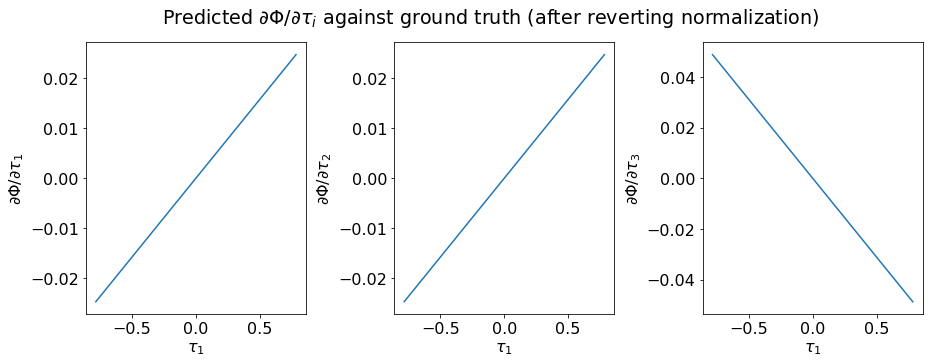

In [58]:
Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

Phi1 = Phi1*out_stdv + out_mean
Phi2 = Phi2*out_stdv + out_mean
Phi3 = Phi3*out_stdv + out_mean

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)
ax[0].plot(tau1, Phi1)
ax[1].plot(tau1, Phi2)
ax[2].plot(tau1, Phi3)

for i, axi in enumerate(ax):
    axi.set(xlabel=r'$\tau_1$', ylabel = r'$\partial \Phi / \partial \tau_{i}$'.format(i=i+1))
fig.suptitle(r'Predicted $\partial \Phi / \partial \tau_i$ against ground truth (after reverting normalization)')
pass

## Train $\Phi^{NODE}$ that contains a single Neural ODE

In [60]:
with open('saved/phi_norm_w_NI12.npy', 'rb') as f:
    [NI12_inp_mean, NI12_inp_stdv, NI12_out_mean, NI12_out_stdv] = pickle.load(f)
with open('saved/phi_params_NI12.npy', 'rb') as f:
    NI12_params = pickle.load(f)

with open('saved/phi_norm_w_NI12m3I2.npy', 'rb') as f:
    [NI12m3I2_inp_mean, NI12m3I2_inp_stdv, NI12m3I2_out_mean, NI12m3I2_out_stdv] = pickle.load(f)
with open('saved/phi_params_NI12m3I2.npy', 'rb') as f:
    NI12m3I2_params = pickle.load(f)

In [75]:
def NI12_pr(taui):
    tau1, tau2, tau3 = taui

    tau1 = (tau1 - NI12_inp_mean)/NI12_inp_stdv
    tau2 = (tau2 - NI12_inp_mean)/NI12_inp_stdv
    tau3 = (tau3 - NI12_inp_mean)/NI12_inp_stdv

    I12 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    N4 = NODE(I12, NI12_params)

    out = 2*N4*(tau1 + tau2 + tau3)
    out = out*NI12_out_stdv + NI12_out_mean
    return out
NI12_pr_vmap = vmap(NI12_pr)

def NI12m3I2_pr(taui):
    tau1, tau2, tau3 = taui

    tau1 = (tau1 - NI12m3I2_inp_mean)/NI12m3I2_inp_stdv
    tau2 = (tau2 - NI12m3I2_inp_mean)/NI12m3I2_inp_stdv
    tau3 = (tau3 - NI12m3I2_inp_mean)/NI12m3I2_inp_stdv

    N5 = NODE(tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3, NI12m3I2_params)

    Phi1 = N5*(2*tau1 - tau2 - tau3)
    Phi2 = N5*(2*tau2 - tau1 - tau3)
    Phi3 = N5*(2*tau3 - tau1 - tau2)

    Phi1 = Phi1*NI12m3I2_out_stdv + NI12m3I2_out_mean
    Phi2 = Phi2*NI12m3I2_out_stdv + NI12m3I2_out_mean
    Phi3 = Phi3*NI12m3I2_out_stdv + NI12m3I2_out_mean
    return [Phi1, Phi2, Phi3]
NI12m3I2_pr_vmap = vmap(NI12m3I2_pr)


#### $\tau_1 \in [-100,100]$, $\tau_2 = \tau_3 = 0$

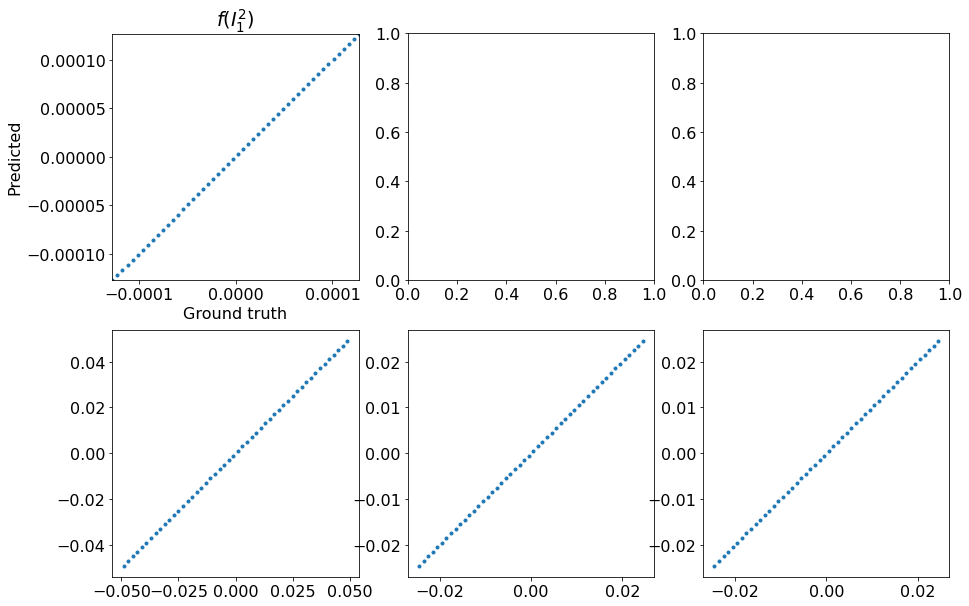

In [95]:
tau1 = np.linspace(-100,100)
tau2 = np.zeros_like(tau1)
tau3 = np.zeros_like(tau2)
taui = np.array([tau1, tau2, tau3]).transpose()

out1_pr = NI12_pr_vmap(taui)
out2_pr = np.array(NI12m3I2_pr_vmap(taui))
etad = 1360
etav = 175000
out1_gt = 2/9/etav*(tau1 + tau2 + tau3)
out2_gt1 = 2*(1/3/etad)*(tau1+tau2+tau3) - 1/etad*(tau2+tau3)
out2_gt2 = 2*(1/3/etad)*(tau1+tau2+tau3) - 1/etad*(tau1+tau3)
out2_gt3 = 2*(1/3/etad)*(tau1+tau2+tau3) - 1/etad*(tau1+tau2)

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax[0,0].plot(out1_gt, out1_pr, '.')
ax[0,0].set(xlim=[np.min(out1_gt), np.max(out1_gt)], 
       ylim=[np.min(out1_gt), np.max(out1_gt)], 
       aspect='equal',
       xlabel='Ground truth',
       ylabel='Predicted',
       title='$f(I_1^2)$')

ax[1,0].plot(out2_gt1, out2_pr[0], '.')
ax[1,1].plot(out2_gt2, out2_pr[1], '.')
ax[1,2].plot(out2_gt3, out2_pr[2], '.')
pass

#### $\tau_1, \tau_2, \tau_3 \sim N(0,50)$

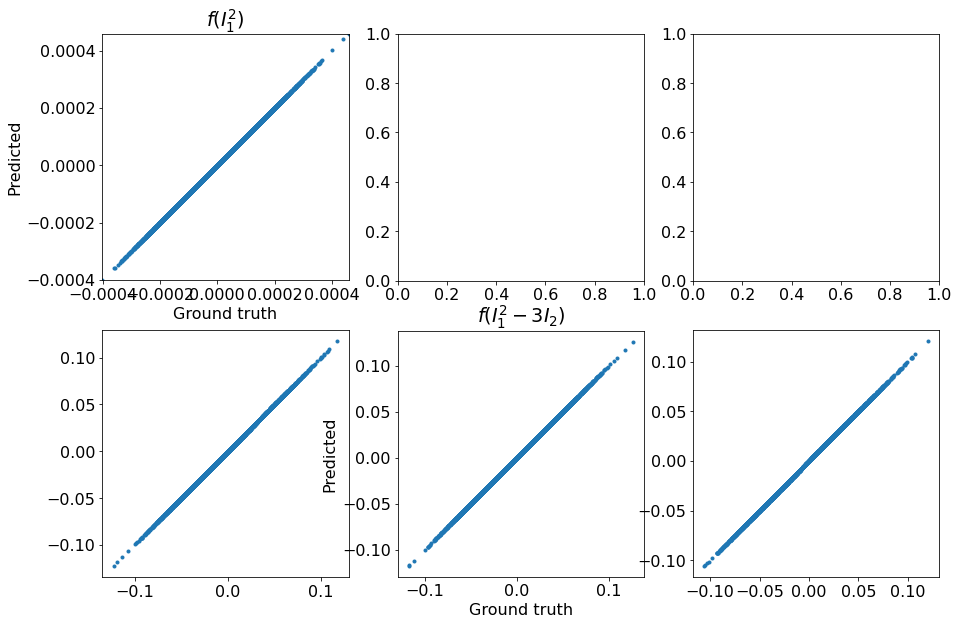

In [122]:
tau1 = onp.random.normal(0,50, size=10000)
tau2 = onp.random.normal(0,50, size=10000)
tau3 = onp.random.normal(0,50, size=10000)
taui = np.array([tau1, tau2, tau3]).transpose()

out1_pr = NI12_pr_vmap(taui)
out2_pr = np.array(NI12m3I2_pr_vmap(taui))
etad = 1360
etav = 175000
out1_gt = 2/9/etav*(tau1 + tau2 + tau3)
out2_gt1 = 2*(1/3/etad)*(tau1+tau2+tau3) - 1/etad*(tau2+tau3)
out2_gt2 = 2*(1/3/etad)*(tau1+tau2+tau3) - 1/etad*(tau1+tau3)
out2_gt3 = 2*(1/3/etad)*(tau1+tau2+tau3) - 1/etad*(tau1+tau2)

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax[0,0].plot(out1_gt, out1_pr, '.')
ax[0,0].set(xlim=[np.min(out1_gt), np.max(out1_gt)], 
       ylim=[np.min(out1_gt), np.max(out1_gt)], 
       aspect='equal',
       xlabel='Ground truth',
       ylabel='Predicted',
       title='$f(I_1^2)$')

ax[1,0].plot(out2_gt1, out2_pr[0], '.')
ax[1,1].plot(out2_gt2, out2_pr[1], '.')
ax[1,2].plot(out2_gt3, out2_pr[2], '.')
ax[1,1].set(aspect='equal',
            xlabel='Ground truth',
            ylabel='Predicted',
            title='$f(I_1^2-3I_2)$')
pass